# Text and Annotation

Creating a good visualization involves guiding the reader so that the figure tells a story.
In some cases, this story can be told in an entirely visual manner, without the need for added text, but in others, small textual cues and labels are necessary.
Perhaps the most basic types of annotations you will use are axes labels and titles, but the options go beyond this.
Let's take a look at some data and how we might visualize and annotate it to help convey interesting information. We'll start by setting up the notebook for plotting and  importing the functions we will use:

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd

## Example: Effect of Holidays on US Births

Let's return to some data we worked with earler, in ["Example: Birthrate Data"](03.09-Pivot-Tables.ipynb#Example:-Birthrate-Data), where we generated a plot of average births over the course of the calendar year; as already mentioned, that this data can be downloaded at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv.

We'll start with the same cleaning procedure we used there, and plot the results:

In [49]:
births = pd.read_csv('births.csv')

quartiles = np.percentile(births['births'], [25, 50, 75])
mu, sig = quartiles[1], 0.74 * (quartiles[2] - quartiles[0])
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

births['day'] = births['day'].astype(int)

births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')
births_by_date = births.pivot_table('births',
                                    [births.index.month, births.index.day])
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]

<ipython-input-49-5be8d9bb83f5>:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  births_by_date.index = [pd.datetime(2012, month, day)


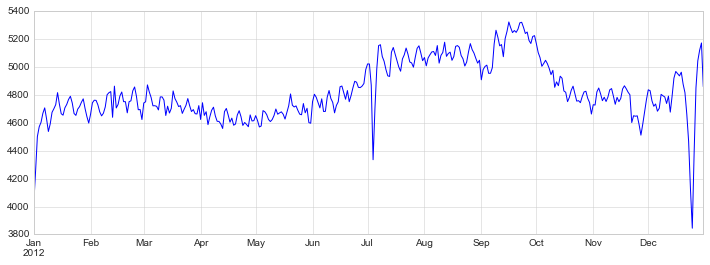

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

When we're communicating data like this, it is often useful to annotate certain features of the plot to draw the reader's attention.
This can be done manually with the ``plt.text``/``ax.text`` command, which will place text at a particular x/y value:

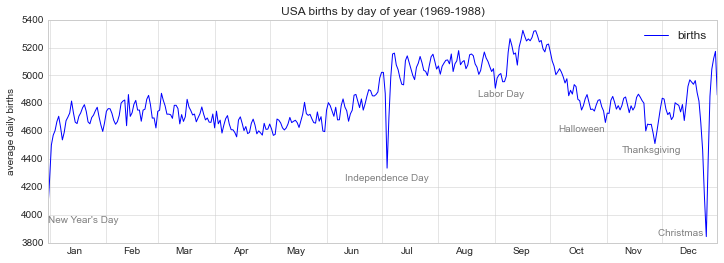

In [58]:
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax)

# Add labels to the plot
style = dict(size=10, color='gray')

ax.text('2012-1-1', 3950, "New Year's Day", **style)
ax.text('2012-7-4', 4250, "Independence Day", ha='center', **style)
ax.text('2012-9-4', 4850, "Labor Day", ha='center', **style)
ax.text('2012-10-31', 4600, "Halloween", ha='right', **style)
ax.text('2012-11-25', 4450, "Thanksgiving", ha='center', **style)
ax.text('2012-12-25', 3850, "Christmas ", ha='right', **style)

# Label the axes
ax.set(title='USA births by day of year (1969-1988)',
       ylabel='average daily births')

# Format the x axis with centered month labels
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%h'));

The ``ax.text`` method takes an x position, a y position, a string, and then optional keywords specifying the color, size, style, alignment, and other properties of the text.
Here we used ``ha='right'`` and ``ha='center'``, where ``ha`` is short for *horizonal alignment*.
See the docstring of ``plt.text()`` and of ``mpl.text.Text()`` for more information on available options.

## Transforms and Text Position

In the previous example, we have anchored our text annotations to data locations. Sometimes it's preferable to anchor the text to a position on the axes or figure, independent of the data. In Matplotlib, this is done by modifying the *transform*.

Any graphics display framework needs some scheme for translating between coordinate systems.
For example, a data point at $(x, y) = (1, 1)$ needs to somehow be represented at a certain location on the figure, which in turn needs to be represented in pixels on the screen.
Mathematically, such coordinate transformations are relatively straightforward, and Matplotlib has a well-developed set of tools that it uses internally to perform them (these tools can be explored in the ``matplotlib.transforms`` submodule).

The average user rarely needs to worry about the details of these transforms, but it is helpful knowledge to have when considering the placement of text on a figure. There are three pre-defined transforms that can be useful in this situation:

- ``ax.transData``: Transform associated with data coordinates
- ``ax.transAxes``: Transform associated with the axes (in units of axes dimensions)
- ``fig.transFigure``: Transform associated with the figure (in units of figure dimensions)

Here let's look at an example of drawing text at various locations using these transforms:

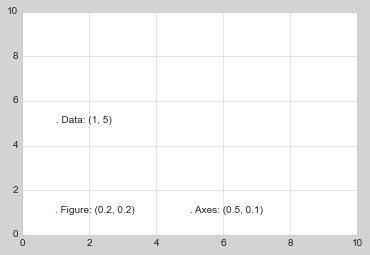

In [67]:
fig, ax = plt.subplots(facecolor='lightgray')
ax.axis([0, 10, 0, 10])

# transform=ax.transData is the default, but we'll specify it anyway
ax.text(1, 5, ". Data: (1, 5)", transform=ax.transData)
ax.text(0.5, 0.1, ". Axes: (0.5, 0.1)", transform=ax.transAxes)
ax.text(0.2, 0.2, ". Figure: (0.2, 0.2)", transform=fig.transFigure);

Note that by default, the text is aligned above and to the left of the specified coordinates: here the "." at the beginning of each string will approximately mark the given coordinate location.

The ``transData`` coordinates give the usual data coordinates associated with the x- and y-axis labels.
The ``transAxes`` coordinates give the location from the bottom-left corner of the axes (here the white box), as a fraction of the axes size.
The ``transFigure`` coordinates are similar, but specify the position from the bottom-left of the figure (here the gray box), as a fraction of the figure size.

**Notice now that if we change the axes limits, it is only the ``transData`` coordinates that will be affected**, while the others remain stationary:

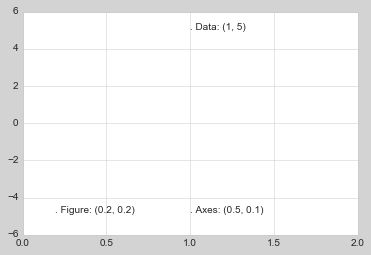

In [ ]:
ax.set_xlim(0, 2)
ax.set_ylim(-6, 6)
fig

This behavior can be seen more clearly by changing the axes limits interactively: if you are executing this code in a notebook, you can make that happen by changing ``%matplotlib inline`` to ``%matplotlib notebook`` and using each plot's menu to interact with the plot.

## Arrows and Annotation

Along with tick marks and text, another useful annotation mark is the simple arrow.

Drawing arrows in Matplotlib is often much harder than you'd bargain for.
While there is a ``plt.arrow()`` function available, I wouldn't suggest using it: the arrows it creates are SVG objects that will be subject to the varying aspect ratio of your plots, and the result is rarely what the user intended.
Instead, I'd suggest using the ``plt.annotate()`` function.
This function creates some text and an arrow, and the arrows can be very flexibly specified.

Here we'll use ``annotate`` with several of its options:

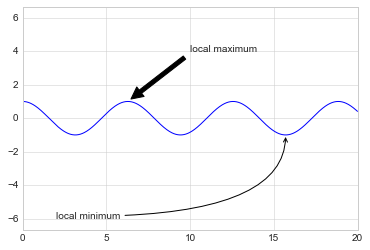

In [71]:
%matplotlib inline

fig, ax = plt.subplots()

x = np.linspace(0, 20, 1000)
ax.plot(x, np.cos(x))
ax.axis('equal')

ax.annotate('local maximum', xy=(6.28, 1), xytext=(10, 4),
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.annotate('local minimum', xy=(5 * np.pi, -1), xytext=(2, -6),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"));

The arrow style is controlled through the ``arrowprops`` dictionary, which has numerous options available.
These options are fairly well-documented in Matplotlib's online documentation, so rather than repeating them here it is probably more useful to quickly show some of the possibilities.
Let's demonstrate several of the possible options using the birthrate plot from before:

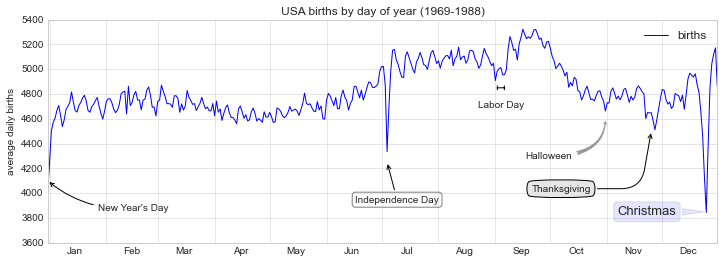

In [72]:
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax)

# Add labels to the plot
ax.annotate("New Year's Day", xy=('2012-1-1', 4100),  xycoords='data',
            xytext=(50, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))

ax.annotate("Independence Day", xy=('2012-7-4', 4250),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, -40), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate('Labor Day', xy=('2012-9-4', 4850), xycoords='data', ha='center',
            xytext=(0, -20), textcoords='offset points')
ax.annotate('', xy=('2012-9-1', 4850), xytext=('2012-9-7', 4850),
            xycoords='data', textcoords='data',
            arrowprops={'arrowstyle': '|-|,widthA=0.2,widthB=0.2', })

ax.annotate('Halloween', xy=('2012-10-31', 4600),  xycoords='data',
            xytext=(-80, -40), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('Thanksgiving', xy=('2012-11-25', 4500),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))


ax.annotate('Christmas', xy=('2012-12-25', 3850),  xycoords='data',
             xytext=(-30, 0), textcoords='offset points',
             size=13, ha='right', va="center",
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1));

# Label the axes
ax.set(title='USA births by day of year (1969-1988)',
       ylabel='average daily births')

# Format the x axis with centered month labels
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%h'));

ax.set_ylim(3600, 5400);

You'll notice that the specifications of the arrows and text boxes are very detailed: this gives you the power to create nearly any arrow style you wish.
Unfortunately, it also means that these sorts of features often must be manually tweaked, a process that can be very **time consuming when producing publication-quality graphics!**
Finally, I'll note that the preceding mix of styles is by no means best practice for presenting data, but rather included as a demonstration of some of the available options.

More discussion and examples of available arrow and annotation styles can be found in the Matplotlib gallery, in particular the [Annotation Demo](http://matplotlib.org/examples/pylab_examples/annotation_demo2.html).

# Customizing Ticks

**Matplotlib's default tick locators and formatters are designed to be generally sufficient in many common situations, but are in no way optimal for every plot**. This section will give several examples of adjusting the tick locations and formatting for the particular plot type you're interested in.

Before we go into examples, it will be best for us to understand further the object hierarchy of Matplotlib plots.
Matplotlib aims to have a Python object representing everything that appears on the plot: for example, recall that the **``figure`` is the bounding box within which plot elements appear.**
Each Matplotlib object can also act as a container of sub-objects: **for example, each ``figure`` can contain one or more ``axes`` objects, each of which in turn contain other objects representing plot contents.**

The tick marks are no exception. Each ``axes`` has attributes ``xaxis`` and ``yaxis``, which in turn have attributes that contain all the properties of the lines, ticks, and labels that make up the axes.

## Major and Minor Ticks

Within each axis, there is the concept of a *major* tick mark, and a *minor* tick mark. As the names would imply, **major ticks are usually bigger or more pronounced, while minor ticks are usually smaller**. By default, Matplotlib rarely makes use of minor ticks, but one place you can see them is within logarithmic plots:

In [1]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np

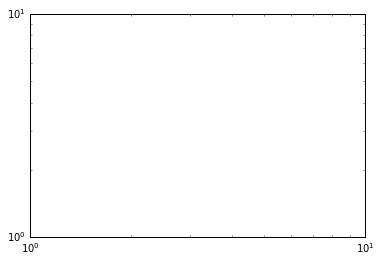

In [2]:
ax = plt.axes(xscale='log', yscale='log')
ax.grid();

We see here that each major tick shows a large tickmark and a label, while each minor tick shows a smaller tickmark with no label.

These tick properties—locations and labels—that is, can be customized by setting the ``formatter`` and ``locator`` objects of each axis. Let's examine these for the x axis of the just shown plot:

In [3]:
print(ax.xaxis.get_major_locator())
print(ax.xaxis.get_minor_locator())

In [4]:
print(ax.xaxis.get_major_formatter())
print(ax.xaxis.get_minor_formatter())

We see that both major and minor tick labels have their locations specified by a ``LogLocator`` (which makes sense for a logarithmic plot). Minor ticks, though, have their labels formatted by a ``NullFormatter``: this says that no labels will be shown.

We'll now show a few examples of setting these locators and formatters for various plots.

## Hiding Ticks or Labels

Perhaps the most common tick/label formatting operation is the act of hiding ticks or labels.
This can be done using ``plt.NullLocator()`` and ``plt.NullFormatter()``, as shown here:

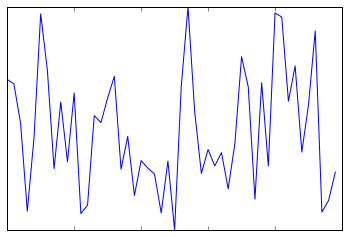

In [15]:
ax = plt.axes()
ax.plot(np.random.rand(50))

ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_formatter(plt.NullFormatter())

**Notice that we've removed the labels (but kept the ticks/gridlines) from the x axis, and removed the ticks (and thus the labels as well) from the y axis.**
Having no ticks at all can be useful in many situations—for example, when you want to show a grid of images.
For instance, consider the following figure, which includes images of different faces, an example often used in supervised machine learning problems (see, for example, [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb)):

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Daney\scikit_learn_data


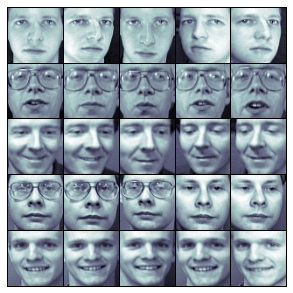

In [16]:
fig, ax = plt.subplots(5, 5, figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

# Get some face data from scikit-learn
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces().images

for i in range(5):
    for j in range(5):
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        ax[i, j].imshow(faces[10 * i + j], cmap="bone")

Notice that each image has its own axes, and we've set the locators to null because the tick values (pixel number in this case) do not convey relevant information for this particular visualization.

## Reducing or Increasing the Number of Ticks

One common problem with the default settings is that smaller subplots can end up with crowded labels.
We can see this in the plot grid shown here:

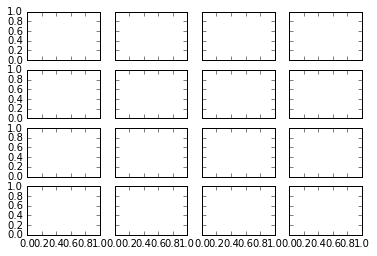

In [17]:
fig, ax = plt.subplots(4, 4, sharex=True, sharey=True)

Particularly for the x ticks, the numbers nearly overlap and make them quite difficult to decipher.
We can fix this with the ``plt.MaxNLocator()``, which allows us to specify the maximum number of ticks that will be displayed.
Given this maximum number, Matplotlib will use internal logic to choose the particular tick locations:

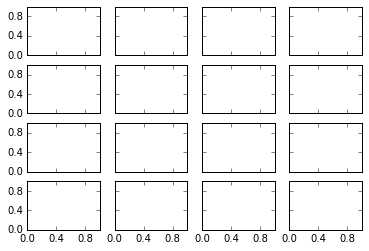

In [18]:
# For every axis, set the x and y major locator
for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(3))
    axi.yaxis.set_major_locator(plt.MaxNLocator(3))
fig

This makes things much cleaner. If you want even more control over the locations of regularly-spaced ticks, you might also use ``plt.MultipleLocator``, which we'll discuss in the following section.

## Fancy Tick Formats

Matplotlib's default tick formatting can leave a lot to be desired: it works well as a broad default, but sometimes you'd like do do something more.
Consider this plot of a sine and a cosine:

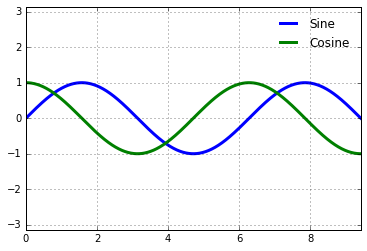

In [20]:
# Plot a sine and cosine curve
fig, ax = plt.subplots()
x = np.linspace(0, 3 * np.pi, 1000)
ax.plot(x, np.sin(x), lw=3, label='Sine')
ax.plot(x, np.cos(x), lw=3, label='Cosine')

# Set up grid, legend, and limits
ax.grid(True)
ax.legend(frameon=False)
ax.axis('equal')
ax.set_xlim(0, 3 * np.pi);

There are a couple changes we might like to make. First, it's more natural for this data to space the ticks and grid lines in multiples of $\pi$. We can do this by setting a ``MultipleLocator``, which locates ticks at a multiple of the number you provide. For good measure, we'll add both major and minor ticks in multiples of $\pi/4$:

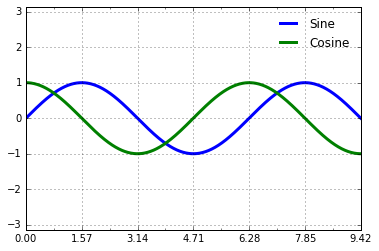

In [21]:
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
fig

But now these tick labels look a little bit silly: we can see that they are multiples of $\pi$, but the decimal representation does not immediately convey this.
To fix this, we can change the tick formatter. There's no built-in formatter for what we want to do, so we'll instead use ``plt.FuncFormatter``, which accepts a user-defined function giving fine-grained control over the tick outputs:

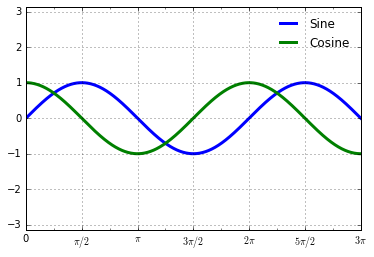

In [ ]:
def format_func(value, tick_number):
    # find number of multiples of pi/2
    N = int(np.round(2 * value / np.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/2$"
    elif N == 2:
        return r"$\pi$"
    elif N % 2 > 0:
        return r"${0}\pi/2$".format(N)
    else:
        return r"${0}\pi$".format(N // 2)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
fig

This is much better! Notice that we've made use of Matplotlib's LaTeX support, specified by enclosing the string within dollar signs. This is very convenient for display of mathematical symbols and formulae: in this case, ``"$\pi$"`` is rendered as the Greek character $\pi$.

The ``plt.FuncFormatter()`` offers extremely fine-grained control over the appearance of your plot ticks, and comes in very handy when preparing plots for presentation or publication.

## Summary of Formatters and Locators

We've mentioned a couple of the available formatters and locators.
We'll conclude this section by briefly listing all the built-in locator and formatter options. For more information on any of these, refer to the docstrings or to the Matplotlib online documentaion.
Each of the following is available in the ``plt`` namespace:

Locator class        | Description
---------------------|-------------
``NullLocator``      | No ticks
``FixedLocator``     | Tick locations are fixed
``IndexLocator``     | Locator for index plots (e.g., where x = range(len(y)))
``LinearLocator``    | Evenly spaced ticks from min to max
``LogLocator``       | Logarithmically ticks from min to max
``MultipleLocator``  | Ticks and range are a multiple of base
``MaxNLocator``      | Finds up to a max number of ticks at nice locations
``AutoLocator``      | (Default.) MaxNLocator with simple defaults.
``AutoMinorLocator`` | Locator for minor ticks

Formatter Class       | Description
----------------------|---------------
``NullFormatter``     | No labels on the ticks
``IndexFormatter``    | Set the strings from a list of labels
``FixedFormatter``    | Set the strings manually for the labels
``FuncFormatter``     | User-defined function sets the labels
``FormatStrFormatter``| Use a format string for each value
``ScalarFormatter``   | (Default.) Formatter for scalar values
``LogFormatter``      | Default formatter for log axes

We'll see further examples of these through the remainder of the book.